In [2]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from functools import partial
import numpy as np
import SimpleITK as sitk # to read nii files
from livelossplot import PlotLossesKerasTF

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental_run_functions_eagerly(True)

In [4]:
DefaultConv3D = partial(keras.layers.Conv3D, kernel_size=3, strides=(1,)*3,
        padding="SAME", use_bias=True)

class ResidualUnit(keras.layers.Layer):
    # separate construction and execution
    # be aware of the strides' shape
    def __init__(self, filters, strides=(1,)*3, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = filters
        self.strides = strides
                
        # a list a layers that can be iterated
        self.main_layers = [
                DefaultConv3D(self.filters, strides=self.strides, kernel_initializer="he_normal"),
                self.activation,
                DefaultConv3D(self.filters, strides=(1,)*3, kernel_initializer="he_normal"),
                ]
        self.skip_layers = []
        if np.prod(self.strides) > 1:
            #self.skip_layers = [keras.layers.MaxPool3D(pool_size=(2,)*3, strides=strides, padding="SAME")]
            
            self.skip_layers = [
                DefaultConv3D(self.filters, kernel_size=1, strides=self.strides, kernel_initializer="he_normal")
                ]          
            
    def call(self, inputs, **kwargs):
        x = inputs
        orig_x = inputs
        
        for layer in self.main_layers:
            x = layer(x) # f(x)
        
        for layer in self.skip_layers:
            orig_x = layer(orig_x)
        
        return self.activation(x + orig_x)
    
    def get_config(self):
        config = super(ResidualUnit, self).get_config()
        config.update({'filters': self.filters, 'strides':self.strides})
        
        return config

In [5]:
#model = keras.models.load_model("./my_logs/Bi_rotate_aug_Classes_epoch371_best.h5", custom_objects={"ResidualUnit": ResidualUnit})

In [6]:
#def backend_reshape(x, shape):
#    return keras.backend.reshape(x, shape)
filters = (16, 32, 64, 128)
strides = (1, 2, 2, 2)
new_model = keras.models.Sequential()

'''
for idx, layer in enumerate(model.layers):
    if idx != len(model.layers) - 1:
        new_model.add(layer)'''
new_model.add(keras.layers.Lambda(lambda x: keras.backend.reshape(x, shape = (-1,48, 96, 96, 1) )))
new_model.add(DefaultConv3D(filters[0], kernel_size=3, strides=(1,)*3,
        input_shape=[48, 96, 96, 1], kernel_initializer="he_normal"))
new_model.add(keras.layers.Activation("relu"))
#new_model.add(keras.layers.MaxPool3D(pool_size=(2,)*3, padding="SAME"))

for filter, stride in zip(filters[1:], strides[1:]):
    new_model.add(ResidualUnit(filter, strides=(stride,)*3))
    new_model.add(ResidualUnit(filter, strides=(1,)*3))

new_model.add(keras.layers.GlobalAvgPool3D())
new_model.add(keras.layers.Flatten()) # 64

#new_model.add(keras.layers.Dropout(0.3))
new_model.add(keras.layers.Lambda(lambda x: keras.backend.reshape(x, shape = (1, -1, 128))))
new_model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True, recurrent_dropout=0.3)))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences= True, recurrent_dropout=0.3)))
new_model.add(keras.layers.Dropout(0.2))
new_model.add(keras.layers.Dense(2, activation = "softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
new_model.compile(loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"])

In [7]:
input = np.zeros(shape = (1, 4, 48, 96, 96, 1), dtype = np.float32)

output = new_model(input)
output.shape

TensorShape([1, 4, 2])

In [8]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  448       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
residual_unit (ResidualUnit) multiple                  42080     
_________________________________________________________________
residual_unit_1 (ResidualUni multiple                  55360     
_________________________________________________________________
residual_unit_2 (ResidualUni multiple                  168128    
_________________________________________________________________
residual_unit_3 (ResidualUni multiple                  2

In [9]:
file_df = pd.read_csv("New_CRNN_file_reference.csv")
file_df.head()

,Sample,File,Label,Group,Turning_point
0,236LT,"['236LT_w1.nii.gz', '236LT_w2.nii.gz']",0,0,inf
1,236LT,"['236LT_w1.nii.gz', '236LT_w2.nii.gz', '236LT_...",0,0,inf
2,236RT,"['236RT_w1.nii.gz', '236RT_w2.nii.gz']",0,0,inf
3,236RT,"['236RT_w1.nii.gz', '236RT_w2.nii.gz', '236RT_...",0,0,inf
4,238LT,"['238LT_w1.nii.gz', '238LT_w2.nii.gz']",0,0,inf


In [10]:
data_path = "../Data"

file_ls = [ ]
label_ls = [ ]
group_ls = [ ]
for _, row in file_df.iterrows():
    files, labels, groups = row[["File", "Label", "Group"]]
    files = files.replace("'", "").split(", ")
    labels = np.array(labels, dtype = np.int)
    groups = np.array(groups, dtype = np.int)
    file_ls.append(files)
    label_ls.append(labels)
    group_ls.append(groups)

In [11]:
np.random.seed(42)
from sklearn.model_selection import train_test_split
train_img, test_img, train_l, test_l = train_test_split(
        file_ls, label_ls, test_size=0.3, random_state=48
)
#del imgs
# split test data into validation and evaluation evenly
val_img, evl_img, val_l, evl_l = train_test_split(
        test_img, test_l, test_size = 0.5, random_state=42
)


In [12]:
def perf_percent(y_ls):
    p_count = 0
    for y in y_ls:
        if y.sum() != 0:
            p_count += 1
    return p_count , len(y_ls)

print(perf_percent(label_ls))
print(perf_percent(train_l))
print(perf_percent(val_l))
print(perf_percent(evl_l))

(93, 440)
(61, 308)
(19, 66)
(13, 66)


In [13]:
def normalization(img):
    if type(img) == sitk.Image:
        img = sitk.GetArrayFromImage(img)
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    img = img[:,:,:,np.newaxis].astype(np.float32)
    return img

def RotateAugmentation(img_ls):
    '''
    Description: rotate the input 3D image along z-axis by random angles 
    Args:
        img: sitk.Image, dimension is 3
    Return: sitk.Image
    '''
    dim = img_ls[0].GetSize()
    translation = [np.random.randint(0, 5), np.random.randint(0, 5), 0]
    angle = np.float64(np.random.randint(0, 360) / 180 * np.pi)
    rotation = [np.float64(0), np.float64(0), angle] # x-axis, y-axis, z-axis angles
    center = [(d-1) // 2 for d in dim]
    transformation = sitk.Euler3DTransform()    
    transformation.SetCenter(center)            # SetCenter takes three args
    transformation.SetRotation(*rotation)         # SetRotation takes three args
    transformation.SetTranslation(translation)
    aug_ls = []
    for img in img_ls:
        img.SetOrigin((0,0,0))
        img.SetSpacing((1.0, 1.0, 1.0))

        aug_img = sitk.Resample(sitk.Cast(img, sitk.sitkFloat32), 
                sitk.Cast(img[0:96, 0:96, :], 
                sitk.sitkFloat32), transformation, 
                sitk.sitkLinear, 0.0, sitk.sitkFloat32
                )
        aug_ls.append(aug_img)
    return aug_ls

def IdentityAugmentation(img_ls):
    return [img[2:98, 2:98, :] for img in img_ls]

def FlipAugmentation(img_ls):
    
    return

In [14]:
def DataGenerator(file_ls, label_ls, augmentation = None, example_n = 6):
    def generator():
        for fs, ys in zip(file_ls, label_ls):
            img_ls = [sitk.ReadImage(os.path.join(data_path, f)) for f in fs]
            if augmentation is not None:
                for i in range(example_n):
                    aug_ls = augmentation(img_ls)
                    yield [normalization(img) for img in aug_ls], ys
                yield [normalization(img[2:98, 2:98]) for img in img_ls], ys
            else:
                yield [normalization(img[2:98, 2:98]) for img in img_ls], ys
    return generator

In [15]:
def DatasetReader(file_ls, label_ls, shuffle_size, batch_size, augmentation = None, example_n = 6):
        generator = DataGenerator(file_ls, label_ls, augmentation = augmentation, example_n = example_n)
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types = (tf.float32, tf.float32),
            output_shapes = (
                tf.TensorShape((None, 48, 96, 96, 1)), 
                tf.TensorShape((None,))
            )
        )
        
        dataset = dataset.repeat().shuffle(shuffle_size).batch(batch_size)
        
        return dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
BATCH_SIZE = 1
SHUBFFLE_SIZE = 160

In [17]:
train_set = DatasetReader(train_img, train_l, 
        shuffle_size = SHUBFFLE_SIZE, 
        batch_size = BATCH_SIZE, augmentation = RotateAugmentation, example_n = 3
)
val_set = DatasetReader(val_img, val_l, 40, BATCH_SIZE) #, augmentation = IdentityAugmentation, example_n = 1, special_multiplier = 1
evl_set = DatasetReader(evl_img, evl_l, 40, BATCH_SIZE)

In [18]:
# test
for l in train_set.take(5):
    print(l[0].shape, l[1].shape)

UnknownError: RuntimeError: Exception thrown in SimpleITK ReadImage: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "../Data\[370RT_w0.nii.gz" does not exist.
Traceback (most recent call last):

  File "c:\users\wangs\documents\mlenv\tf2.0\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 221, in __call__
    ret = func(*args)

  File "c:\users\wangs\documents\mlenv\tf2.0\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 585, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-14-efa5cb272723>", line 4, in generator
    img_ls = [sitk.ReadImage(os.path.join(data_path, f)) for f in fs]

  File "<ipython-input-14-efa5cb272723>", line 4, in <listcomp>
    img_ls = [sitk.ReadImage(os.path.join(data_path, f)) for f in fs]

  File "c:\users\wangs\documents\mlenv\tf2.0\lib\site-packages\SimpleITK\SimpleITK.py", line 8876, in ReadImage
    return _SimpleITK.ReadImage(*args)

RuntimeError: Exception thrown in SimpleITK ReadImage: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "../Data\[370RT_w0.nii.gz" does not exist.


	 [[{{node PyFunc}}]] [Op:IteratorGetNextSync]

In [19]:
#================== Configure Callbacks ==================
#_{epoch}
checkpoint_cb = keras.callbacks.ModelCheckpoint("../CRNN_logs/Bidirectional_Bi_C-RNN/Bidirectional_Bi_C-RNN_{epoch}_no_batch_norm.h5", 
        monitor = 'val_accuracy', mode = 'max',
        save_best_only=True
        )

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f} \n".format(logs["val_loss"] / logs["loss"]))

root_logdir = os.path.join(os.curdir, "my_logs/Bidirectional_Bi_C-RNN")

def get_run_logdir(comment="_no_batch_norm"):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S{}".format(comment))
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

plotlosses = PlotLossesKerasTF()
callbacks = [checkpoint_cb, tensorboard_cb, plotlosses]

ModuleNotFoundError: No module named 'livelossplot'

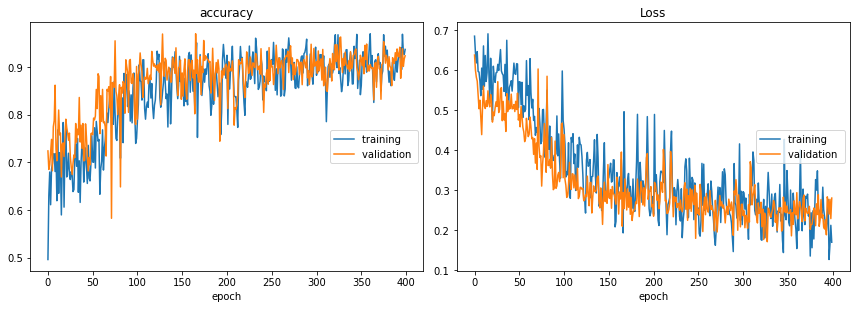

accuracy
	training         	 (min:    0.496, max:    0.974, cur:    0.937)
	validation       	 (min:    0.212, max:    0.969, cur:    0.923)
Loss
	training         	 (min:    0.126, max:    0.696, cur:    0.169)
	validation       	 (min:    0.171, max:    0.832, cur:    0.280)
40/40 - 6s - loss: 0.1695 - accuracy: 0.9365 - val_loss: 0.2800 - val_accuracy: 0.9231


In [93]:
history = new_model.fit(train_set, steps_per_epoch = 40, epochs = 400,
                       validation_data = val_set,
                        initial_epoch = 0,
                       validation_steps = 40,
                       callbacks = callbacks, verbose = 2
                       )

In [ ]:
new_model.load_weights("./my_logs/Bidirectional_Bi_C-RNN/Bidirectional_Bi_C-RNN_166_no_batch_norm.h5")


In [99]:
new_model.evaluate(evl_set, steps = 20)

20/20 [==============================] - 2s 76ms/step - loss: 0.4368 - accuracy: 0.8333


[0.4367631621658802, 0.8333333]

In [75]:
x_ls = []
for bidx, fs in enumerate(file_ls):
    x = np.zeros(shape = (1, 5, 48, 96, 96, 1))
    xls = []
    for sidx, imgf in enumerate(fs):
        img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_path,imgf)))
        img = normalization(img[:, 2:98, 2:98])
        xls.append(img)
        
    x_ls.append(np.array(xls)[np.newaxis])

In [83]:
correct_count = 0
wrong_count = 0
pred_bi = []
pred_y = []
for x, y in zip(x_ls, label_ls):
    x = np.array(x)
    x = x[np.newaxis, :, :]
    pred = new_model.predict_classes(np.array(x))
    print("Predicted is : {}    ; True label is: {}    ;".format(np.squeeze(pred), np.array(y)))
    print()
    a = all(np.squeeze(pred) == np.array(y))
    pred_bi.append(a)
    pred_y.append(np.squeeze(pred))
    if a:
        correct_count += 1
    else:
        wrong_count += 1

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0]    ; True label is: [0 0]    ;

Predicted is : [0 0]    ; True label is: [0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 1]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label 

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 1 1]    ; True label is: [0 1 1]    ;

Predicted is : [0 1 1 1]    ; True label is: [0 1 1 1]    ;

Predicted is : [0 0 0 0]    ; True label is: [0 0 0 0]    ;

Predicted is : [0 0 0 0 0]    ; True label is: [0 0 0 0 1]    ;

Predicted is : [0 0 1 1]    ; True label is: [0 0 1 1]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted is : [0 0 0]    ; True label is: [0 0 0]    ;

Predicted i

In [84]:
print(correct_count)
print(wrong_count)
print(correct_count / (wrong_count + correct_count))

188
73
0.7203065134099617


In [42]:
transit_points = []
for y in label_ls:
    y = np.array(y)
    trans = 1
    for idx, j in enumerate(y):
        if j == 0:
            trans += 1
        elif j == 1:
            continue
            
        if idx == (y.shape[0] - 1) and j == 0:
            trans = 'Infinity'
            
    transit_points.append(str(trans))
    print(y, trans)

[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0] Infinity
[0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 1] 3
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0] Infinity
[0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[0 1] 2
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[0 1 1] 2
[0 1] 2
[0 1] 2
[1 1] 1
[1 1] 1
[1 1] 1
[1 1] 1
[0 1 1] 2
[0 1] 2
[1 1] 1
[0 0] Infinity
[1 1] 1
[0 0] Infinity
[0 0 1] 3
[0 0 1] 3
[1 1 1] 1
[0 0 1] 3
[1 1] 1
[0 1] 2
[0 0 0] Infinity
[0 0 1] 3
[0 0 1] 3
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Infinity
[0 0 0] Inf

In [60]:
acc_df = pd.DataFrame()
acc_df['Transition_point'] = transit_points
acc_df['y_True'] = label_ls
acc_df['y_pred'] = pred_y
acc_df['T/F'] = pred_bi

In [100]:
acc_df[['Transition_point','T/F']].groupby('Transition_point').mean()

,T/F
Transition_point,
1,0.888889
2,0.294118
3,0.428571
4,0.333333
5,0.000000
Infinity,0.946970


In [5]:
file_df.shape

(261, 4)